In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib agg

import jax
import jax.numpy as jnp
import visualization
from utils import results, experiments, settings, equioutput, evaluation
import os
import global_settings
rng_key, rng_key_ = jax.random.split(jax.random.PRNGKey(0))

In [2]:
result = results.ResultSample.load_from_file(
    os.path.join(
        global_settings.PATH_PAPER_RESULTS,
        "{}.tar.gz".format(
            # 1 3
            #"6414c528c5f8cc0c9f08578de5fb1dbc" # sinusoidal
            #"e851ba9827843f1e59e7369eb2bf4c91" # izmailov
            #"8a230f135f7b260f93605b6a86792887" # regression2d
            #"56979997b79aee53358f54ab83744a40" # airfoil
            #"4b7feaf16650a91b2aa9dcb6c9e050ef" # concrete
            #"f080a1a860b0bd3fb634d896d425f188" # diabetes
            #"5946d6a0855fbf1f537f500cf21c52c1" # energy
            #"4025c365e874ac9da74267ae6a61a44b" # forest_fire
            #"15e48cdb7200d362fd2d7e86e0b8776f" # wine
            "a3d7403396b047211ec7a86f39015bb8" # yacht
        )
    )
)
experiment = experiments.FactoryExperiment(result.experiment_type, **{"settings": result.settings})()
print(experiment._settings)

SettingsExperimentSample(output_path='/home/ubuntu/data/experiments/paper/results', dataset='yacht', dataset_normalization='standardization', hidden_layers=1, hidden_neurons=3, activation='tanh', activation_last_layer='none', num_warmup=1024, statistic='reduced', statistic_p=0.99, samples_per_chain=1, identifiable_modes=3, pool_size=10, seed=0, overwrite_chains=None)


In [3]:
print(result.dataset.shape)

(308, 7)


In [4]:
print(result.indices_train)

[12, 232, 10, 73, 302, 142, 67, 105, 249, 114, 18, 282, 90, 161, 1, 108, 36, 3, 215, 190, 279, 275, 147, 113, 146, 47, 14, 307, 75, 122, 59, 196, 39, 197, 256, 58, 82, 285, 100, 287, 252, 28, 258, 260, 130, 87, 111, 85, 101, 185, 191, 89, 203, 123, 187, 239, 186, 236, 77, 29, 281, 88, 303, 129, 42, 269, 171, 72, 27, 154, 241, 246, 231, 227, 69, 110, 40, 95, 257, 34, 261, 21, 242, 179, 201, 117, 20, 13, 23, 22, 225, 267, 244, 235, 213, 205, 163, 174, 251, 106, 119, 273, 296, 292, 255, 24, 169, 148, 109, 168, 195, 160, 15, 60, 270, 240, 93, 116, 259, 194, 207, 68, 188, 211, 157, 48, 230, 43, 189, 50, 306, 81, 229, 104, 155, 297, 63, 131, 115, 217, 212, 198, 132, 149, 293, 265, 250, 226, 70, 301, 76, 136, 268, 135, 276, 41, 137, 286, 247, 2, 25, 91, 32, 49, 99, 151, 204, 139, 165, 31, 125, 33, 121, 176, 133, 54, 5, 53, 283, 37, 284, 71, 158, 222, 16, 300, 118, 200, 8, 278, 199, 253, 238, 263, 78, 289, 61, 288, 234, 175, 290, 138, 224, 180, 221, 280, 124, 6, 264, 218, 141, 184, 86, 126, 26

In [5]:
print(result.indices_test)

[181, 17, 102, 170, 107, 182, 172, 294, 66, 202, 223, 208, 164, 243, 150, 145, 266, 57, 299, 167, 134, 80, 262, 271, 45, 248, 7, 233, 84, 65, 183, 245, 62, 144, 98, 210, 74, 214, 305, 64, 219, 206, 9, 178, 46, 216, 192, 209, 128, 277, 193, 4, 291, 254, 103, 143, 96, 83, 51, 56, 11, 228]


# qualitative

100%|██████████████████████████████████████████████████████████| 25/25 [00:11<00:00,  2.27it/s]


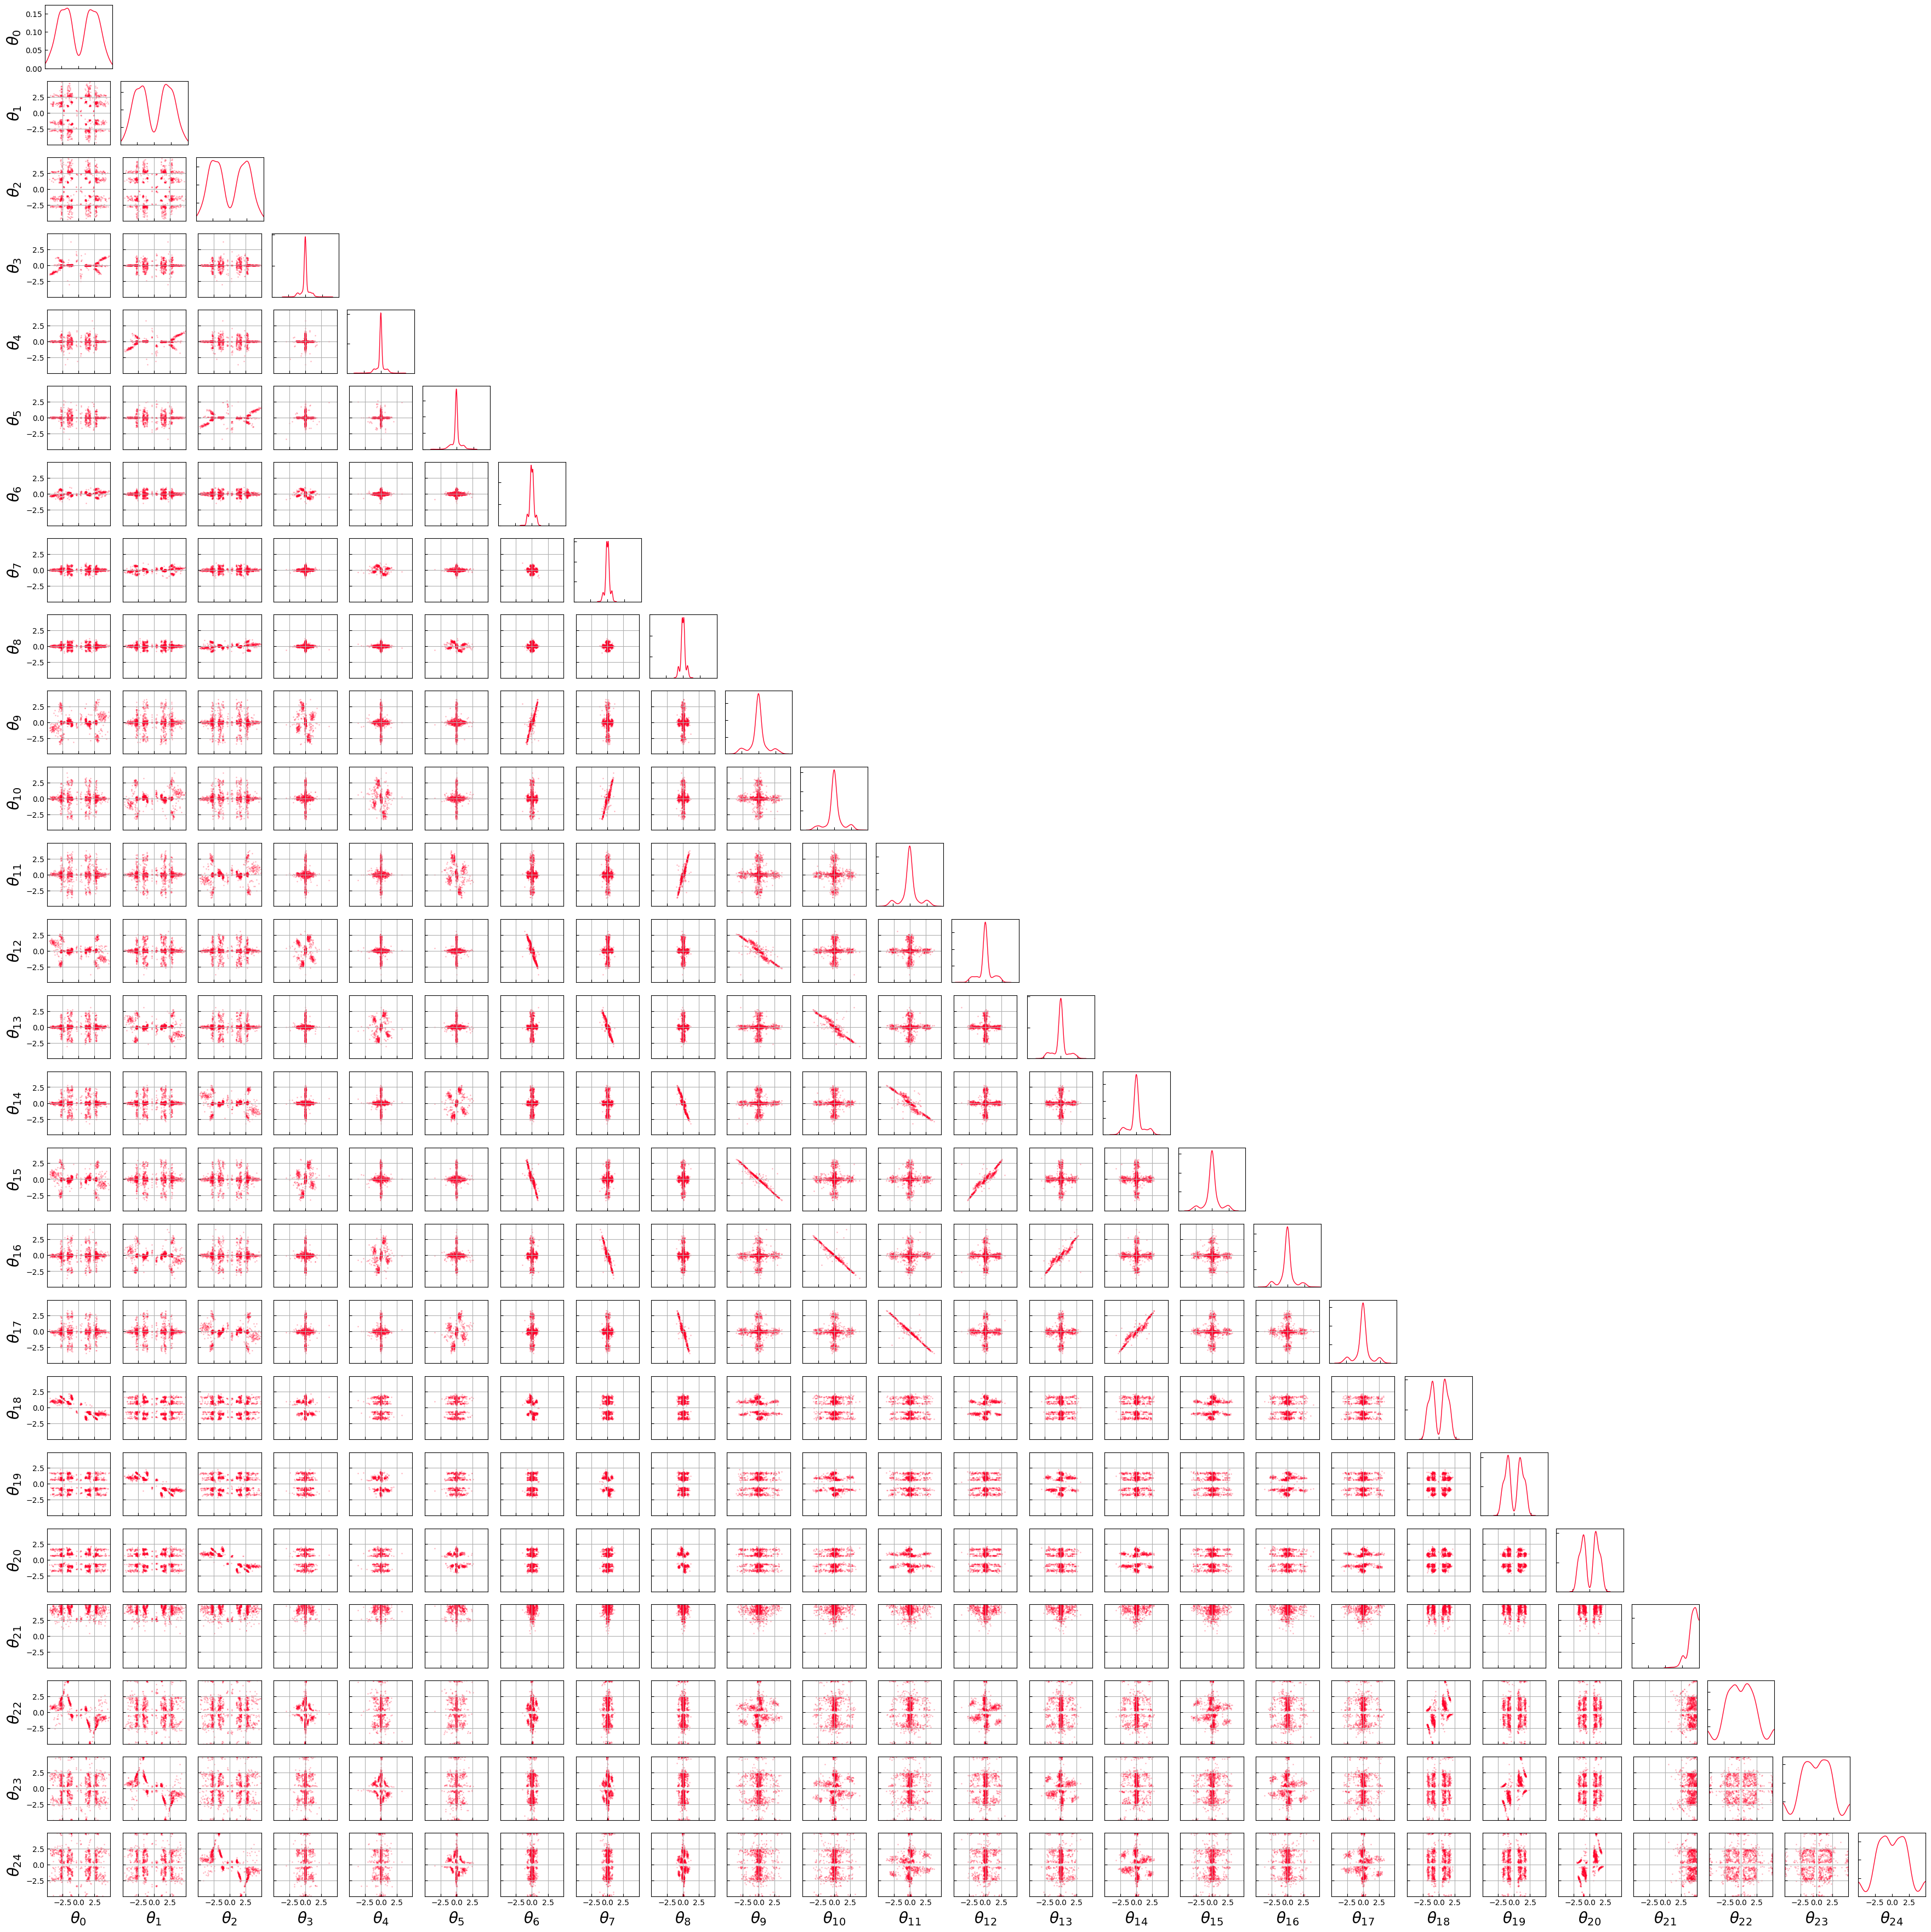

In [6]:
import matplotlib
rng_key, rng_key_ = jax.random.split(rng_key)

figure = visualization.TriangleFigure(
    settings=settings.SettingsTriangleFigure(
        prefix=r"\theta",
        settings_scatter=settings.SettingsScatter(
            alpha=0.2,
            size=1.0
        ),
        label_size=20
    )
)
figure.plot(
    data_list=[result.samples["parameters"]]
)

0.03439869


100%|████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


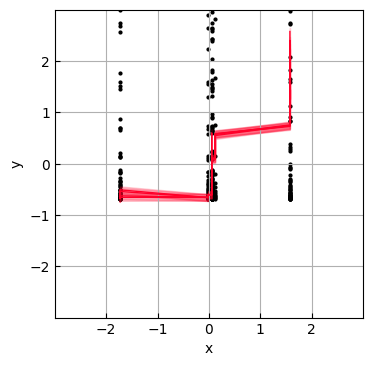

In [7]:
print(result.samples["std"].mean())
figure = visualization.RegressionFigure(
    settings=settings.SettingsRegressionFigure(
        settings_plot=settings.SettingsPlot(
            alpha=1.0,
            aleatoric=True
        )
    ),
)
figure.plot(
    dataset=experiment._dataset,
    transformation=experiment._model_transformation.apply_from_vector,
    parameters_list=[result.samples["parameters"][:4]],
    std=result.samples["std"].mean(),
    feature=0
)

# quantitative

In [8]:
"""
for a prediction - what do i have to do:
* i have to calculate p(y|x, D) which is density of gaussian mixtures, then maximize it?

for nll, i just compute the likelihood
"""


'\nfor a prediction - what do i have to do:\n* i have to calculate p(y|x, D) which is density of gaussian mixtures, then maximize it?\n\nfor nll, i just compute the likelihood\n'

In [9]:
def computed_lppd_mcmc(inputs, outputs, parameters_network, parameters_data_std, regression_model):
    """variant of lppd for mcmc samples"""
    outer_sum = 0
    for xi, yi in zip(inputs, outputs):
        yi_preds = jax.vmap(regression_model._transformation.apply_from_vector, in_axes=(None, 0))(xi, parameters_network)
        probs_mean = jnp.exp(regression_model._outputs_likelihood(
            yi_preds,
            parameters_data_std).log_prob(yi)).mean(axis=0)
        outer_sum += jnp.log(probs_mean)
    return outer_sum

#def computed_lppd_la(inputs, outputs, la_posterior_mu, la_posterior_covariance, n_samples, regression_model):
def computed_lppd_la(inputs, outputs, parameters_network, regression_model):
    """variant of lppd for laplace approximation"""
    #parameters_network = distributions.MultivariateNormal(
    #    la_posterior_mu,
    #    la_posterior_covariance
    #).sample((n_samples, )) # n_samples = 1274
    
    outer_sum = 0
    for xi, yi in zip(inputs, outputs):
        yi_preds = jax.vmap(regression_model._transformation.apply_from_vector, in_axes=(None, 0))(xi, parameters_network)
        probs_mean = jnp.exp(regression_model._outputs_likelihood(yi_preds, parameters_data_std).log_prob(yi)).mean(axis=0)
        outer_sum += jnp.log(probs_mean)
    return outer_sum

def computed_lppd_de(inputs, outputs, parameters_network, regression_model):
    """not ready"""
    """variant of lppd for deep ensembles"""
    outer_sum = 0
    for xi, yi in zip(inputs, outputs):
        yi_preds = jax.vmap(regression_model._transformation.apply_from_vector, in_axes=(None, 0))(xi, parameters_network)
        probs_mean = jnp.exp(regression_model._outputs_likelihood(yi_preds, parameters_data_std).log_prob(yi)).mean(axis=0)
        outer_sum += jnp.log(probs_mean)
    return outer_sum

lppd_result = computed_lppd_mcmc(
    inputs=experiment._dataset.data_test[:, experiment._dataset.conditional_indices],
    outputs=experiment._dataset.data_test[:, experiment._dataset.dependent_indices],
    parameters_network=result.samples["parameters"],
    parameters_data_std=result.samples["std"],
    regression_model=experiment._model
)
print("dataset {}, lppd for model: {}".format(experiment.dataset, lppd_result.item()))

lppd for model: 117.5866928100586
